In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('/content/DOM_hourly.csv',index_col=[0], parse_dates=[0])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DOM_MW,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.0,21651.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [5]:
df.isnull().sum()

DOM_MW    0
dtype: int64

In [6]:
df.dtypes

DOM_MW    float64
dtype: object

<Axes: title={'center': 'Power Consumption From 2002 to 2018 '}, xlabel='Datetime'>

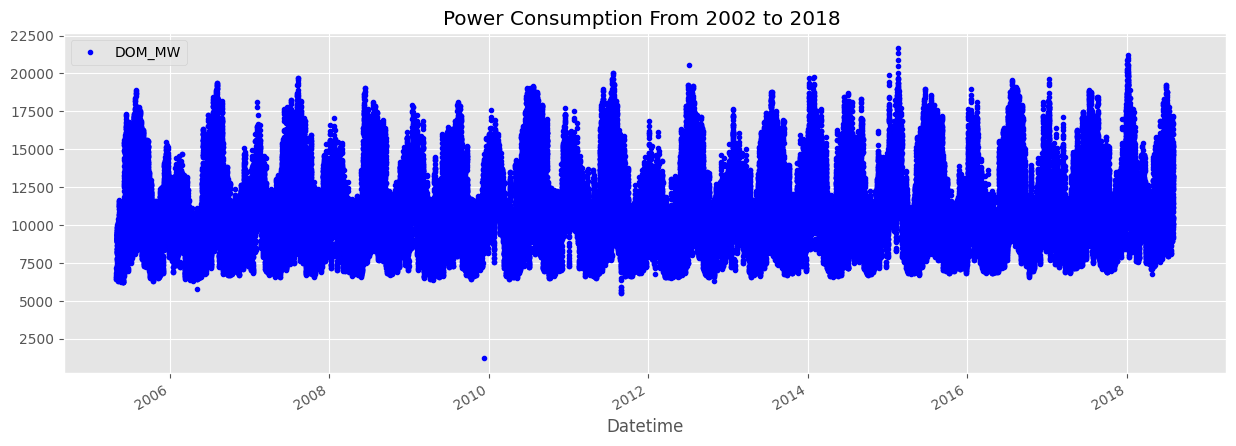

In [7]:
df.plot(style = '.',figsize = (15, 5), title = 'Power Consumption From 2002 to 2018 ',color='blue')

Text(0.5, 1.0, 'Power Distribution Of PJMW Load')

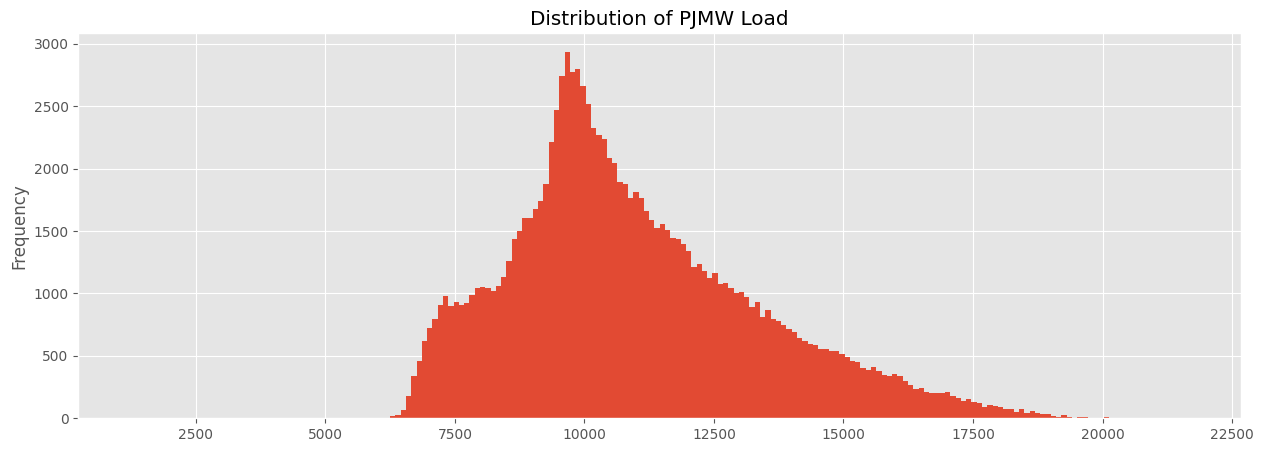

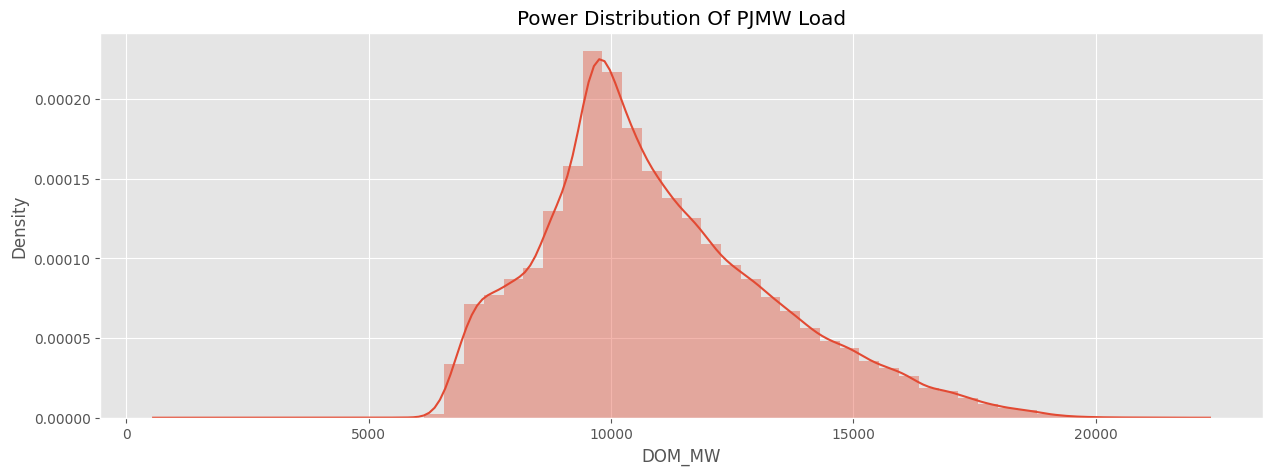

In [8]:
fig, ax = plt.subplots()
df['DOM_MW'].plot.hist(figsize = (15, 5), bins = 200, title = 'Distribution of PJMW Load')

fig, ax = plt.subplots(figsize = (15, 5))
sns.distplot(df['DOM_MW'])
plt.title('Power Distribution Of PJMW Load')

In [9]:
def features(df , label = None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  df['weekday'] = df.index.strftime('%A')

  x = df[['date','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday']]

  if label:
    y = df[label]
    return x, y
  return x

In [10]:
x, y = features(df ,label= 'DOM_MW')
features = pd.concat([x, y], axis=1)
features.tail()

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,DOM_MW
Datetime,,,,,,,,,,,
2018-01-01 20:00:00,2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Monday,18418.0
2018-01-01 21:00:00,2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Monday,18567.0
2018-01-01 22:00:00,2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Monday,18307.0
2018-01-01 23:00:00,2018-01-01 23:00:00,23,0,1,1,2018,1,1,1,Monday,17814.0
2018-01-02 00:00:00,2018-01-02 00:00:00,0,1,1,1,2018,2,2,1,Tuesday,17428.0


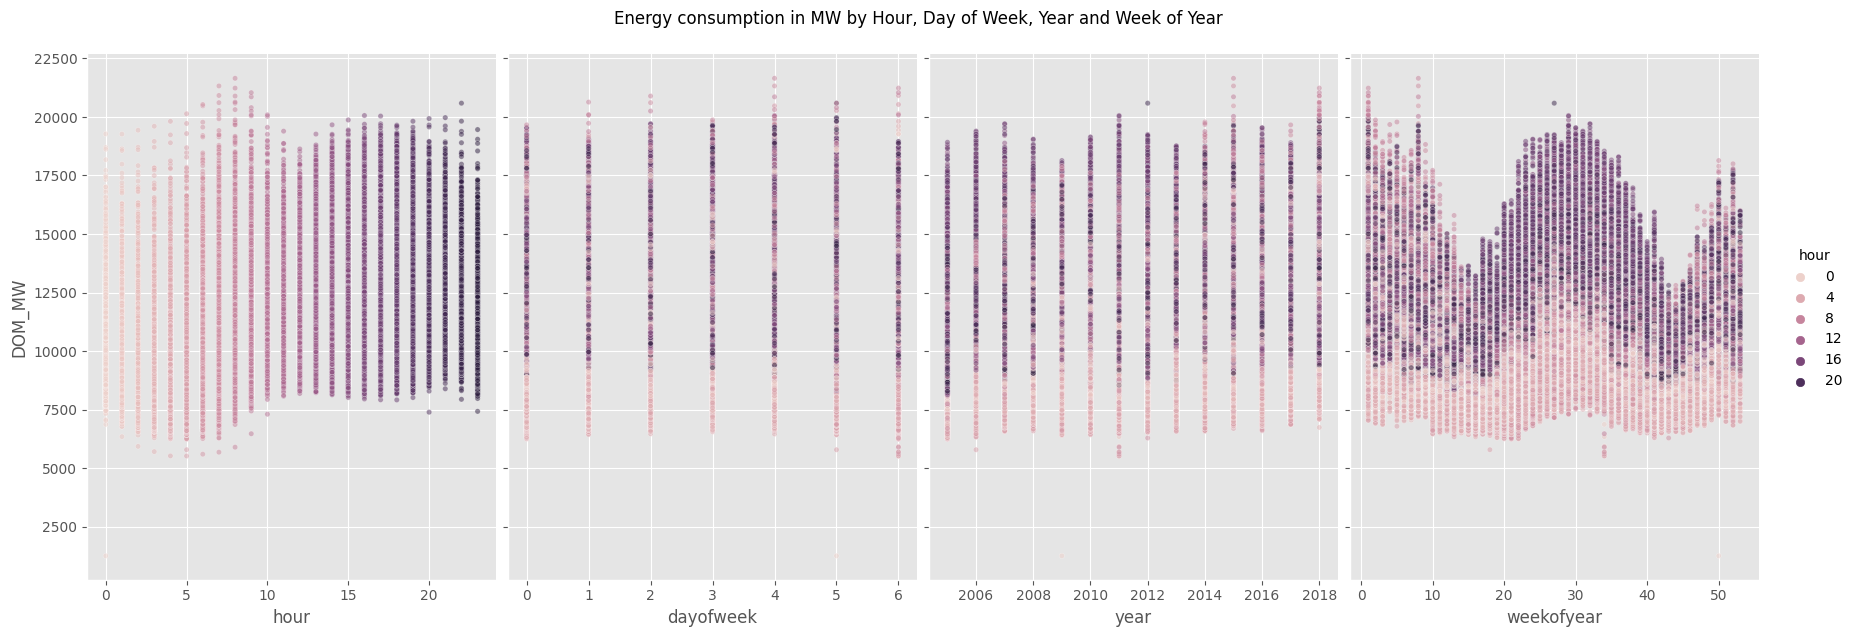

In [11]:
sns.pairplot(features.dropna(),
             hue='hour',
             x_vars=['hour', 'dayofweek', 'year', 'weekofyear'],
             y_vars='DOM_MW',
             height=6,
             aspect=0.75,
             plot_kws=dict(s=15, alpha=0.5),
             diag_kws=dict(alpha=0.5)
            )
plt.suptitle('Energy consumption in MW by Hour, Day of Week, Year and Week of Year', y=1.05)
plt.show()


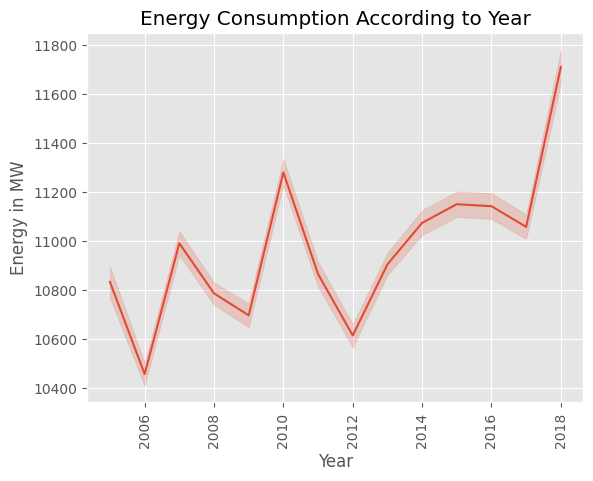

In [12]:
sns.lineplot(x='year', y='DOM_MW', data=features)
plt.title("Energy Consumption According to Year")
plt.xlabel("Year")
plt.ylabel("Energy in MW")
plt.xticks(rotation=90)
plt.grid(True)

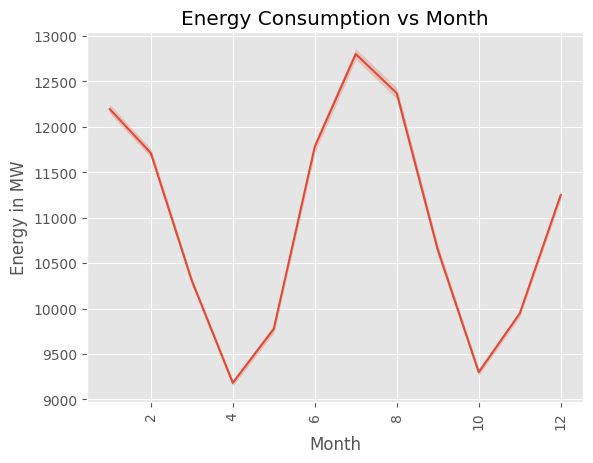

In [13]:
sns.lineplot(x='month', y='DOM_MW', data=features)
plt.title("Energy Consumption vs Month")
plt.xlabel("Month")
plt.ylabel("Energy in MW")
plt.xticks(rotation=90)
plt.grid(True, alpha=1)

<Axes: title={'center': 'DOM_MW - Daily Trends'}, xlabel='hour'>

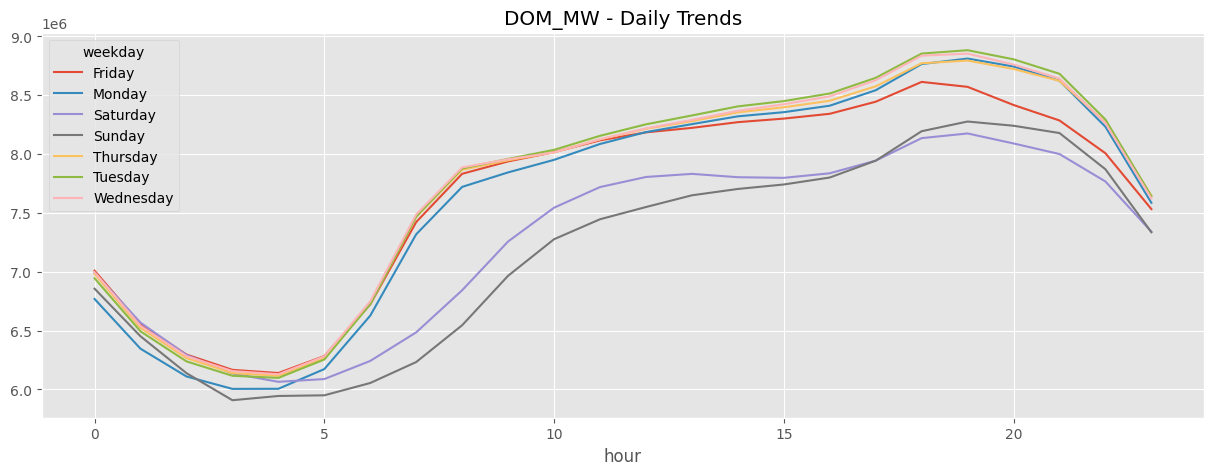

In [14]:
features.pivot_table(index=features['hour'], 
                     columns='weekday', 
                     values='DOM_MW',
                     aggfunc='sum').plot(figsize=(15,5),
                     title='DOM_MW - Daily Trends')

In [15]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))

DOM_MW_Norm = df['DOM_MW']
DOM_MW_Norm.shape

(116189,)

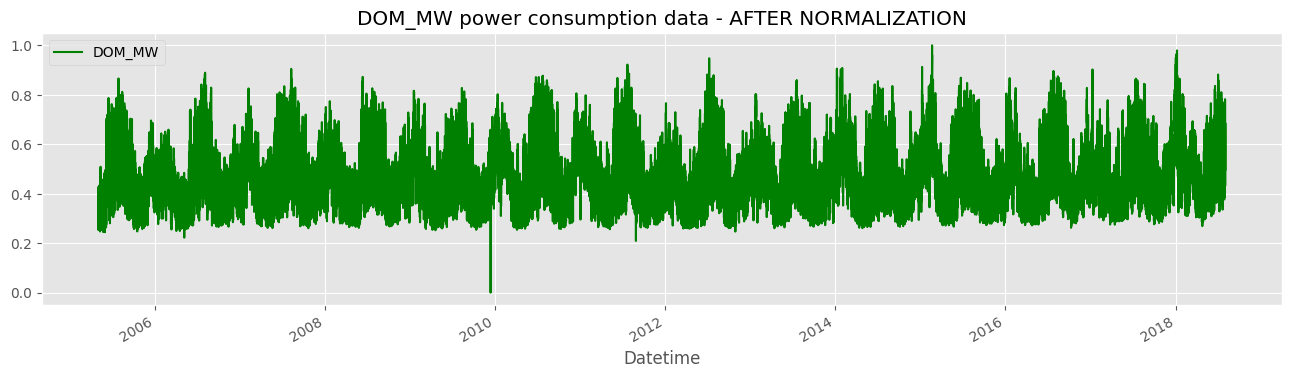

In [16]:
DOM_MW_Norm.plot(figsize=(16,4),legend=True,color='green')

plt.title('DOM_MW power consumption data - AFTER NORMALIZATION')
plt.show()

In [17]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [18]:
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [19]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [20]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 36s 283ms/step - loss: 0.0201
Epoch 2/10
110/110 [==============================] - 30s 274ms/step - loss: 0.0124
Epoch 3/10
110/110 [==============================] - 31s 287ms/step - loss: 0.0095
Epoch 4/10
110/110 [==============================] - 30s 269ms/step - loss: 0.0053
Epoch 5/10
110/110 [==============================] - 30s 276ms/step - loss: 0.0043
Epoch 6/10
110/110 [==============================] - 29s 263ms/step - loss: 0.0035
Epoch 7/10
110/110 [==============================] - 29s 266ms/step - loss: 0.0029
Epoch 8/10
110/110 [==============================] - 29s 268ms/step - loss: 0.0024
Epoch 9/10
110/110 [==============================] - 31s 278ms/step - loss: 0.0021
Epoch 10/10
110/110 [==============================] - 29s 268ms/step - loss: 0.0019


In [21]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 4s 11ms/step
R^2 Score of LSTM model =  0.9417511658642315


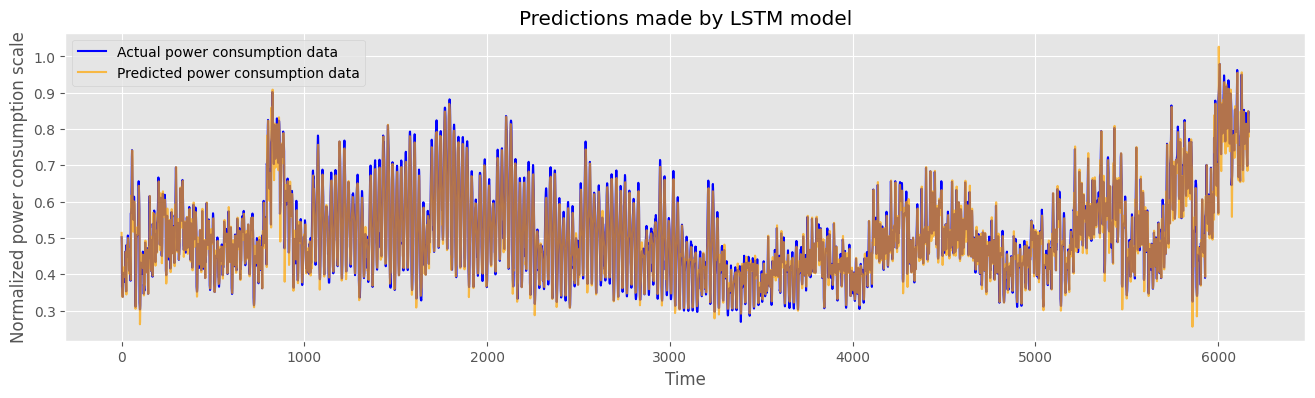

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color='blue', label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='orange', label='Predicted power consumption data')
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [66]:
val_data = pd.read_csv('/content/powervalidate.csv',index_col=[0], parse_dates=[0])
val_data.head()

,DOM_MW
Datetime,
2022-04-01 04:00:00,9663.778
2022-04-01 05:00:00,9391.423
2022-04-01 06:00:00,9179.308
2022-04-01 07:00:00,9090.752
2022-04-01 08:00:00,9232.191


In [67]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-04-01 04:00:00 to 2023-04-01 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DOM_MW  8761 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


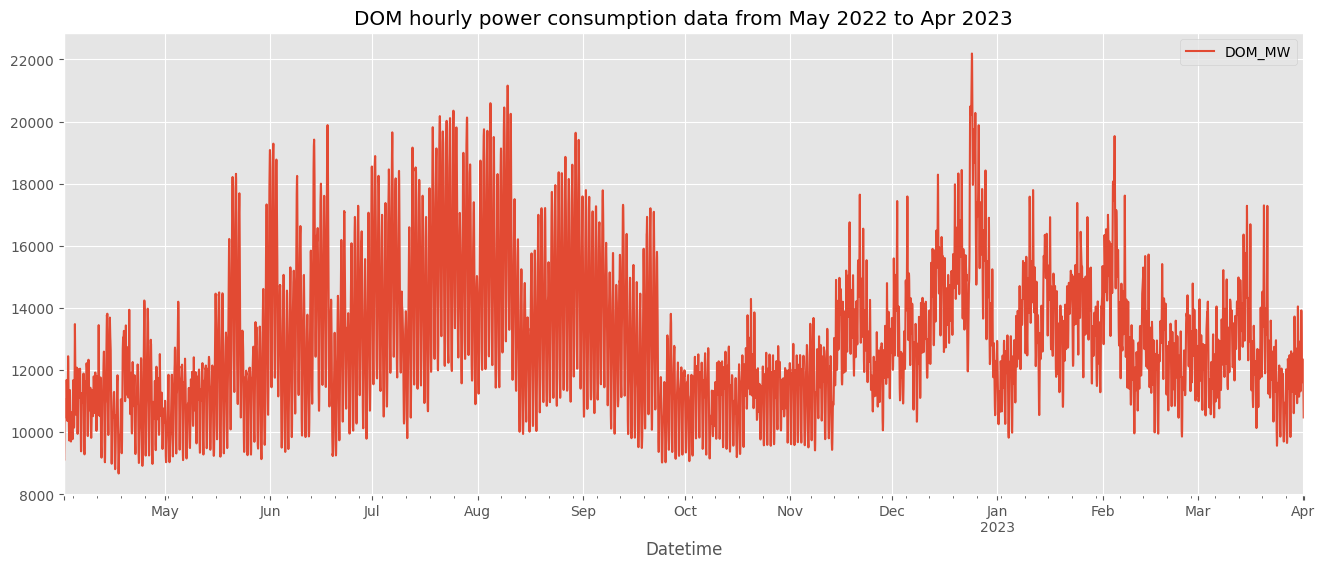

In [68]:
val_data.plot(figsize=(16,6),legend=True)
plt.title('DOM hourly power consumption data from May 2022 to Apr 2023')
plt.show()

In [70]:
def features(df , label = None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  df['weekday'] = df.index.strftime('%A')

  x = df[['date','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday']]

  if label:
    y = df[label]
    return x, y
  return x

In [71]:
x, y = features(val_data ,label= 'DOM_MW')
features = pd.concat([x, y], axis=1)
features.tail()

,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,DOM_MW
Datetime,,,,,,,,,,,
2023-04-01 00:00:00,2023-04-01 00:00:00,0,5,2,4,2023,91,1,13,Saturday,12182.460
2023-04-01 01:00:00,2023-04-01 01:00:00,1,5,2,4,2023,91,1,13,Saturday,11844.578
2023-04-01 02:00:00,2023-04-01 02:00:00,2,5,2,4,2023,91,1,13,Saturday,11366.456
2023-04-01 03:00:00,2023-04-01 03:00:00,3,5,2,4,2023,91,1,13,Saturday,10890.435
2023-04-01 04:00:00,2023-04-01 04:00:00,4,5,2,4,2023,91,1,13,Saturday,10475.077


In [72]:
scaler = sklearn.preprocessing.MinMaxScaler()
val_data['DOM_MW']=scaler.fit_transform(val_data['DOM_MW'].values.reshape(-1,1))

In [73]:
val_data['DOM_MW'].shape

(8761,)

In [74]:
def load_data(stock, seq_len):
    X_val = []
    y_val = []
    for i in range(seq_len, len(stock)):
        X_val.append(stock.iloc[i-seq_len : i, 0])
        y_val.append(stock.iloc[i, 0])
    
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], seq_len, 1))
    
    
    return X_val, y_val

In [75]:
seq_len = 20 

X_val, y_val = load_data(val_data, seq_len)

print('X_val.shape = ',X_val.shape)
print('y_val.shape = ',y_val.shape)

X_val.shape =  (8741, 20, 1)
y_val.shape =  (8741,)


In [76]:
lstm_predictions = lstm_model.predict(X_val)

274/274 [==============================] - 3s 11ms/step


In [77]:
lstm_score = r2_score(y_val, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.940505029152086


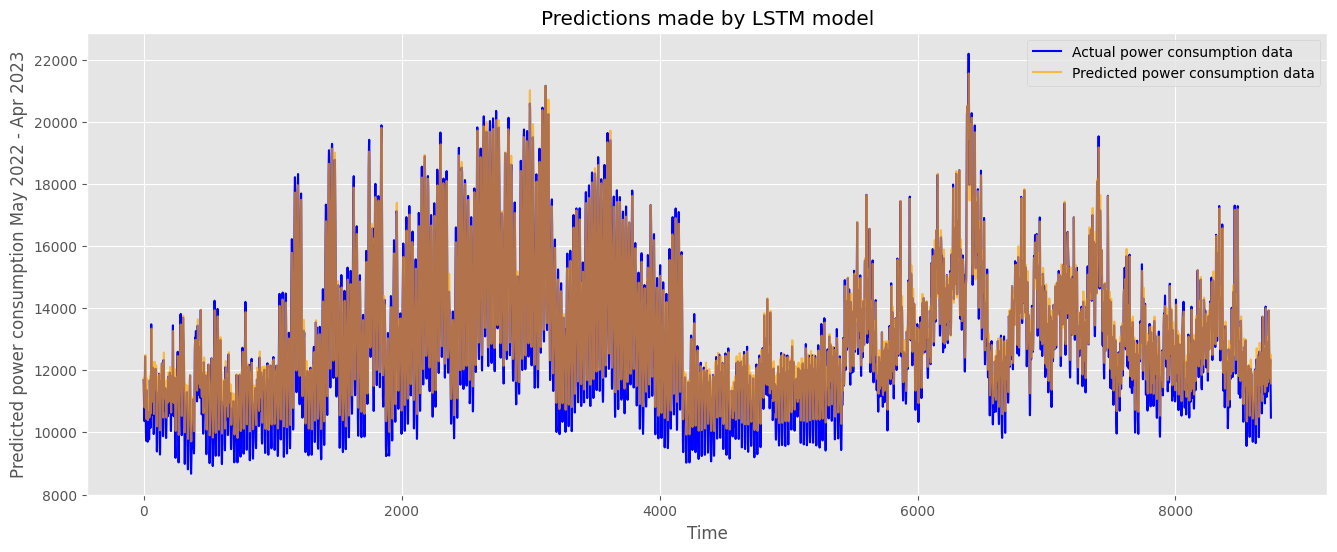

In [78]:
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_val = scaler.inverse_transform(y_val.reshape(-1,1))
plt.figure(figsize=(16, 6))
plt.plot(y_val, color='blue', label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='orange', label='Predicted power consumption data')
plt.title("Predictions made by LSTM model")
plt.xlabel('Time')
plt.ylabel('Predicted power consumption May 2022 - Apr 2023')
plt.legend()
plt.show()